# Translation with Transformer

- Download Dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [1]:
from pathlib import Path
trg_path = Path('/gdrive/Shareddrives/Dion-Account/data')

In [ ]:
# !wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {trg_path}

--2021-12-21 01:32:47--  https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.78.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.78.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598183296 (2.4G) [application/x-tar]
Saving to: ‘/gdrive/Shareddrives/Dion-Account/data/giga-fren.tgz’

giga-fren.tgz       100%[===================>]   2.42G  35.7MB/s    in 77s     

2021-12-21 01:34:05 (32.0 MB/s) - ‘/gdrive/Shareddrives/Dion-Account/data/giga-fren.tgz’ saved [2598183296/2598183296]



In [ ]:
# !tar -xf {trg_path}/giga-fren.tgz -C {trg_path}

In [2]:
Path.ls = lambda x: list(x.iterdir())

In [3]:
(trg_path/'giga-fren').ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/data/giga-fren/giga-fren.release2.fixed.en')]

In [4]:
path = trg_path/'giga-fren'

In [7]:
# with open(path/'giga-fren.release2.fixed.fr') as f: fr = f.read().split('\n')
# with open(path/'giga-fren.release2.fixed.en') as f: en = f.read().split('\n')
# import re
# re_eq = re.compile('^(Wh[^?.!]+\?)')
# re_fq = re.compile('^([^?.!]+\?)')
# lines = ((re_eq.search(eq), re_fq.search(fq))
#     for eq, fq, in zip(open(path/'giga-fren.release2.fixed.fr'), open(path/'giga-fren.release2.fixed.fr')))
# qs = [(e.group(), f.group()) for e, f in lines if e and f]
# import pandas as pd
# df = pd.DataFrame({'fr':[ q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr']) 
# df.to_csv(path/'question_easy.csv', index=False)

In [18]:
df_load = pd.read_csv(path/'question_easy.csv')

In [20]:
df_load.head()

,en,fr
0,What's at Stake for Developing Countries?,What's at Stake for Developing Countries?
1,What is the solution?,What is the solution?
2,Which of the following thoughts are likely to ...,Which of the following thoughts are likely to ...
3,Why does it always have to be my fault?,Why does it always have to be my fault?
4,Why can't she leave this alone?,Why can't she leave this alone?


In [21]:
trg_path.ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/data/giga-fren.tgz'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/data/giga-fren')]

---

In [22]:
import torch

### Positional Encoding

In [24]:
d_model = 20
freq_ls = 1/(10000**(torch.arange(0., d_model, 2.) / d_model))
# we have these positions
positions = torch.arange(0, 100).float()

In [25]:
inp=torch.outer(positions, freq_ls); # 100,10

In [26]:
res = torch.cat([inp.sin(), inp.cos()], dim=-1) #100, 20

$$PE(pos,2i) =sin(pos/10000^{2i/d_{model}})$$  
$$PE(pos,2i+1) =cos(pos/10000^{2i/d_{model}})$$

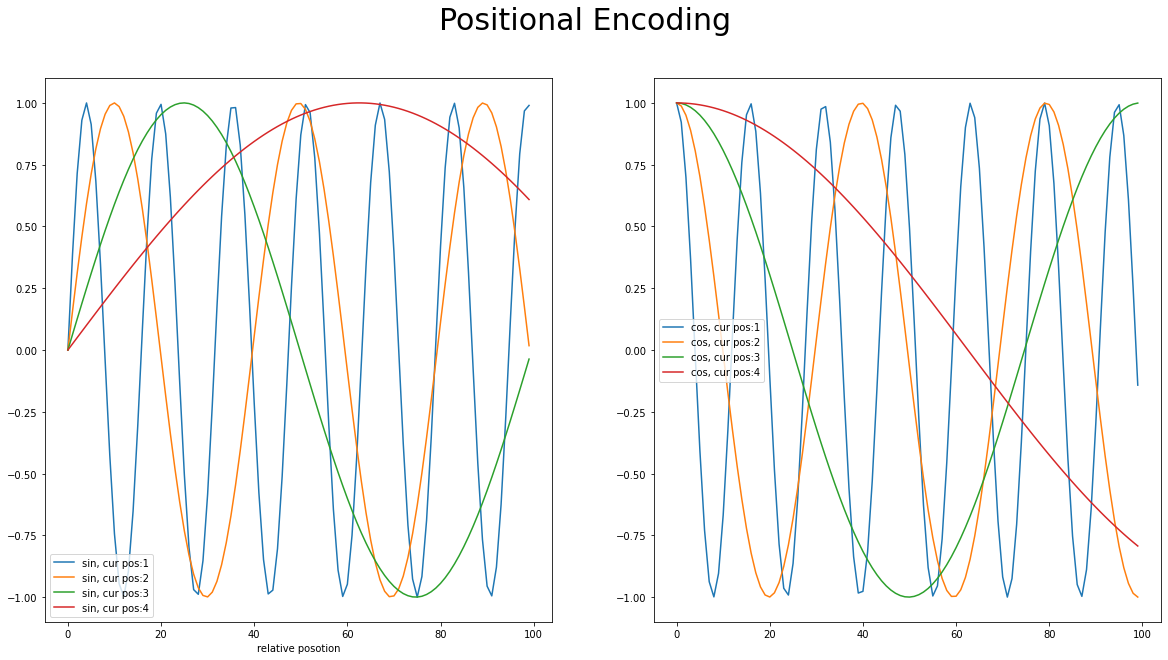

In [60]:
# even -> sin, odd -> cos
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Positional Encoding", fontsize=30)

for i in range(1,5):
    ax[0].plot(res[:,i], label=f"sin, cur pos:{i}")
    ax[0].legend()
    ax[0].set_xlabel("relative posotion")
    ax[1].plot(res[:,int(d_model/2+i)], label=f"cos, cur pos:{i}"); ax[1].legend()


In [48]:
from torch import nn

In [49]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int):
        super().__init__()
        self.register_buffer('freq', 1/(10000 ** (torch.arange(0, d_model, 2.))))
    def __call__(self, pos):
        inp = torch.outer(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [61]:
positions = torch.arange(0, 100)

In [62]:
positions

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [66]:
pe = PositionalEncoding(26)
pe(positions[:2])

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00],
        [8.4147e-01, 1.0000e-08, 1.0000e-16, 1.0000e-24, 1.0000e-32, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.4030e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00]])

## TransformerEmbedding

In [ ]:
class TransformerEmbedding(nn.Module):
    